In [1]:
# import torch
import numpy as np

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.is_available())

# Data

In [3]:
import os
import pickle

filename = './../../data/dump/stack_processed.pickle'
if os.path.isfile(filename):
    with open(filename, 'rb') as handle:
        print("Processed Dictionary Exists!")
        data = pickle.load(handle)
        print(len(data))
else:
    data = process_elements(data)
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Processed Dictionary Exists!
12476


In [4]:
print(type(data))
print(len(data.keys()))

<class 'dict'>
12476


In [5]:
for key, val in data.items():
    print(key,'\n',val)
    print(len(val))
    break

16417 
 [['Enlightened', '2012-01-01T00:03:01.507'], ['Guru', '2012-01-01T19:04:49.853'], ['Nice Answer', '2012-01-03T17:13:43.787'], ['Enlightened', '2012-01-03T17:23:42.043'], ['Nice Answer', '2012-01-05T10:57:24.007'], ['Guru', '2012-01-12T13:09:34.843'], ['Nice Answer', '2012-01-19T16:34:48.097'], ['Enlightened', '2012-01-19T17:00:02.863'], ['Nice Answer', '2012-01-23T11:42:02.033'], ['Good Answer', '2012-01-23T12:27:28.380'], ['Good Answer', '2012-01-25T11:16:11.520'], ['Nice Answer', '2012-01-25T11:36:25.427'], ['Guru', '2012-01-26T15:00:22.013'], ['Guru', '2012-02-02T02:45:31.187'], ['Nice Answer', '2012-02-03T01:48:37.610'], ['Guru', '2012-02-05T20:09:54.550'], ['Nice Answer', '2012-02-08T16:04:37.400'], ['Enlightened', '2012-02-08T19:56:29.803'], ['Guru', '2012-02-13T07:00:19.827'], ['Nice Answer', '2012-02-14T12:23:58.273'], ['Popular Question', '2012-02-15T08:05:53.820'], ['Nice Answer', '2012-02-17T08:52:07.060'], ['Enlightened', '2012-02-17T08:52:10.133'], ['Nice Answer', 

In [6]:
import matplotlib.pyplot as plt

## Lengths of sequences

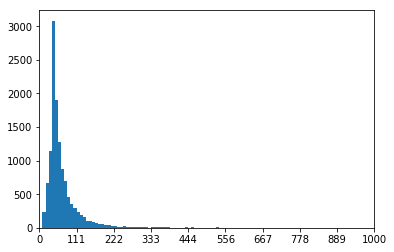

In [7]:
plt.hist(list(map(len, data.values())), bins=500)
plt.xlim(0,1000)
plt.xticks(np.linspace(0,1000,10, endpoint=True))
plt.show()

## Convert to dataframe

In [8]:
import pandas
import numpy as np

In [10]:
def stackex_correct_datatypes(stackex_df):

    # TIMES
    stackex_df['timestamp'] = stackex_df['timestamp'].astype('datetime64[ms]')

    # INTS
    stackex_df['userid'] = stackex_df['userid'].astype('int')
    
    
    return stackex_df

In [132]:
def stackex_data_to_df(data, colnames=None):
    flat_data = [{'userid':idx_user, 'marker': x, 'timestamp': t} for idx_user, data_user in data.items() for x,t in data_user]
    stackex_df = pandas.DataFrame(flat_data)
    stackex_df = stackex_correct_datatypes(stackex_df)
    
    # Make marker a categorical variable
    unique_marker_labels = stackex_df['marker'].unique()
    stackex_df['marker'] = stackex_df['marker'].apply(lambda x: np.argwhere(x==unique_marker_labels).item())
    
    # Sort values first by userid and then by timestamp..
    stackex_df = stackex_df.sort_values(by=['userid', 'timestamp', 'marker'], axis='rows')
    
    # Remove duplicates userid - timestamp pairs as per the RMTPP paper
    stackex_df = stackex_df.drop_duplicates(subset=['userid', 'timestamp'], keep=False)
    
    return stackex_df

In [133]:
stackex_df = stackex_data_to_df(data)

In [134]:
print(stackex_df.info())
stackex_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846736 entries, 409408 to 872591
Data columns (total 3 columns):
marker       846736 non-null int64
timestamp    846736 non-null datetime64[ns]
userid       846736 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 25.8 MB
None


,marker,timestamp,userid
409408,20,2012-01-10 12:31:56.193,1
409409,19,2012-01-10 12:41:55.853,1
409410,19,2012-01-10 12:41:55.883,1
409411,17,2012-01-10 14:27:59.660,1
409412,6,2012-01-18 10:42:35.803,1


## Analyze the badges

In [135]:
_s = stackex_df['marker'].value_counts()
print(_s.values)

[284357 148489 112774  44332  43784  37285  32590  24414  18836  17815
  14141  13886  11787  10359   7024   6453   4506   3940   3876   1972
   1435   1347    530    529    221     54]


In [136]:
_s.index

Int64Index([ 4,  6,  2,  0, 10,  9,  3, 13,  8, 14, 15, 11,  1, 18, 17, 12,  5,
            24, 22, 25, 23, 16,  7, 19, 20, 21],
           dtype='int64')

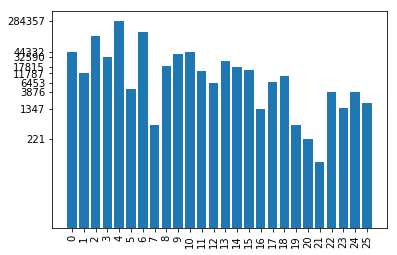

In [137]:
plt.bar(_s.index, np.log(_s.values))
plt.xticks(ticks=_s.index, rotation='vertical')
plt.yticks(ticks=np.log(_s.values)[::3], labels=_s.values[::3])
plt.show()

In [156]:
x_data = []
group_users = stackex_df.groupby('userid')

for user_idx, user_df_rows in group_users.groups.items():
    user_markers = stackex_df.loc[user_df_rows]['marker']
    user_markers = user_markers.values.reshape(len(user_df_rows),-1)
#     t_i, marker_dim = user_markers.shape # marker_dim will be 1 here
    x_data.append(user_markers)

In [162]:
len(x_data), x_data[0].shape, x_data[0][:5]

(12476, (67, 1), array([[20],
        [19],
        [19],
        [17],
        [ 6]]))

In [233]:
t_data = []
group_users = stackex_df.groupby('userid')

for user_idx, user_df_rows in group_users.groups.items():
    user_times = stackex_df.loc[user_df_rows]['timestamp']
    # Shift creates a NaT value at the first entry. Replace it with a zero in the end
    user_times = user_times.astype('int') / (10**9 * 3600 * 24 * 365.25)
    user_intervals = user_times - user_times.shift(periods=1)
    user_intervals.iloc[0] = 0
    t_data_i = np.stack([user_times.values, user_intervals.values], axis=1)
    t_data.append(t_data_i)
    

In [234]:
len(t_data), t_data[0].shape, t_data[0][:5]

(12476, (67, 2), array([[4.20247014e+01, 0.00000000e+00],
        [4.20247204e+01, 1.90020787e-05],
        [4.20247204e+01, 9.50642232e-10],
        [4.20249220e+01, 2.01655924e-04],
        [4.20463963e+01, 2.14742611e-02]]))